In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

import argparse
from copy import deepcopy
import logging
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.signal import butter, lfilter
from sklearn.metrics import r2_score
import sys

sys.path.append('../..')

from data_utils import *
from iaaft import surrogates

sys.path.append('../../../DeLASE')
from delase import *
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *
from plot import *

# Load Data

In [3]:
def swap_phase(x, y):
    new_x = np.zeros(x.shape)
    new_y = np.zeros(y.shape)
#     n_fft = 2000
    n_fft = x.shape[0]
    for i in range(x.shape[1]):
        x_fft = np.fft.fft(x[:, i], n=n_fft)
        y_fft = np.fft.fft(y[:, i], n=n_fft)

        x_mag, x_angle = np.abs(x_fft), np.angle(x_fft)
        y_mag, y_angle = np.abs(y_fft), np.angle(y_fft)
        
        new_x[:, i] = np.real(np.fft.ifft(x_mag*np.exp(1j*y_angle), n=n_fft))
        new_y[:, i] = np.real(np.fft.ifft(y_mag*np.exp(1j*x_angle), n=n_fft))
    return new_x, new_y

def gen_surrogate(x, verbose=True):
    surr = np.zeros(x.shape)
    for i in tqdm(range(surr.shape[1]), disable=not verbose):
        surr[:, i] = surrogates(x[:, i], 1, verbose=False)
    
    return surr

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    if len(data.shape) == 1:
        y = lfilter(b, a, data)
    else:
        y = np.zeros(data.shape)
        for i in range(y.shape[1]):
            y[:, i] = lfilter(b, a, data[:, i])
    return y

In [4]:
session_list = os.listdir("/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/grid_search_results")
session_list = session_list[:2]

In [5]:
save_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/surrogate_testing'
use_torch=True
device='cuda'
num_pairs = 20

In [ ]:
for session in session_list:
    print("-"*30)
    print(f'SESSION = {session}')
    print("-"*30)
    norm_folder="NOT_NORMED"
    # -----------------------------------------
    # LOAD DATA AND DIRECTORY
    # -----------------------------------------
    print("loading data...")
    all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
    data_class = get_data_class(session, all_data_dir)

    os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
    # variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
    # session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
    # electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

    variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
    session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
    electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

    eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose'] 
    section_times = dict( 
            pre=(0, session_info['drugStart'][0]),
            induction=(session_info['drugStart'][0], eyes_close),
            during=(eyes_close, session_info['drugEnd'][1]),
            post=(session_info['drugEnd'][1], T*dt)
    )
    sections = list(section_times.keys())
    areas = np.unique(electrode_info['area'])

    print("loading directory")

    chunked_folder = [f for f in os.listdir(os.path.join(all_data_dir, data_class)) if f.startswith(session) and 'chunked' in f]
    if len(chunked_folder) == 0:
        print(f"Chunked folder for {session} not found in {os.path.join(all_data_dir, data_class)}")
    else:
        chunked_folder = chunked_folder[0]

    directory = pd.read_pickle(os.path.join(all_data_dir, data_class, chunked_folder, 'directory'))

    print("directory loaded!")

    # -----------------------------------------
    # LOAD GRID RESULTS
    # -----------------------------------------

    print("Loading grid search results...")
    
    session_results = {}
    session_results[session] = {}
    # data_processing_df_grid = deepcopy(mp_args.data_processing_df)

    grid_results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/grid_search_results'
    areas = os.listdir(os.path.join(grid_results_dir, session, norm_folder))

    for area in areas:
        df = pd.DataFrame({'window': [], 'matrix_size': [], 'r': [], 'AICs': [], 'time_vals': [], 'file_paths': []}).set_index(['window', 'matrix_size', 'r'])
        for f in os.listdir(os.path.join(grid_results_dir, session, norm_folder, area)):
            t = float(f.split('_')[0])
            file_path = os.path.join(grid_results_dir, session, norm_folder, area, f)
            df_new = pd.DataFrame(pd.read_pickle(file_path))
            if np.isnan(df_new.AIC).sum() > 0:
                print(file_path)
            df_new = df_new.set_index(['window', 'matrix_size', 'r'])
            for i, row in df_new.iterrows():
                if i in df.index:
                    df.loc[i, 'AICs'].append(row.AIC)
                    df.loc[i, 'time_vals'].append(t)
                    df.loc[i, 'file_paths'].append(file_path)
                else:
                    df.loc[i] = {'AICs': [row.AIC], 'time_vals': [t], 'file_paths': [file_path]}

        df = df.loc[df.index.sortlevel()[0]]
        session_results[session][area] = df

    print("Grid search results loaded!")

    # ================
    # INDIVIDUAL AREAS
    # ================ 
    window_ind, matrix_size_ind, r_ind, all_results = combine_grid_results({key: result for key, result in session_results[session].items() if key !='all'})

    # ================
    # ALL AREAS
    # ================ 
    if 'all' in session_results[session].keys():
        window_all, matrix_size_all, r_all, all_results_all = combine_grid_results({key: result for key, result in session_results[session].items() if key =='all'})
    
    # ================
    # SURROGATE ANALYSIS
    # ================ 
    
    wake_bounds = (3*60, session_info['drugStart'][0] - 3*60)
    anesthesia_bounds = (session_info['drugStart'][0] + 15*60, session_info['drugEnd'][1] - 15*60)
    
    print("Now computing all pairs for session:")
    iterator = tqdm(total=len(areas)*num_pairs)
    
    for area in areas:
        print("-"*20)
        print(f"AREA = {area}")
        print("-"*20)
        area_dir = os.path.join(save_dir, session, area)
        os.makedirs(area_dir, exist_ok=True)

        if area == 'all':
            electrode_indices = np.arange(len(electrode_info['area']))
            window, matrix_size, r = window_ind, matrix_size_ind, r_ind
        else:
            electrode_indices = np.where(electrode_info['area'] == area)[0]
            window, matrix_size, r = window_all, matrix_size_all, r_all

        for pair_num in range(num_pairs):
            
            print("-"*10)
            print(f"PAIR = {pair_num}")
            print("-"*10)

            wake_start = np.random.uniform(wake_bounds[0], wake_bounds[1])
            anesthesia_start = np.random.uniform(anesthesia_bounds[0], anesthesia_bounds[1])

            signals = {}

            print("loading signals..")
            signals['wake'] = load_window_from_chunks(wake_start, wake_start + window*dt, directory, dimension_inds=electrode_indices)
            signals['anesthesia'] = load_window_from_chunks(anesthesia_start, anesthesia_start + window*dt, directory, dimension_inds=electrode_indices)

            
            signals['wake_phase_swapped'], signals['anesthesia_phase_swapped'] = swap_phase(signals['wake'], signals['anesthesia'])
            
            print("Computing IAAFTs...")
            signals['wake_iaaft'] = gen_surrogate(signals['wake'])
            signals['anesthesia_iaaft'] = gen_surrogate(signals['anesthesia'])

            band_info = dict(
                delta=(1, 4),
                theta=(4, 8),
                alpha=(8, 13),
                beta=(13, 30),
                gamma=(30, 80),
                high_gamma=(80, 130)
            )
            # https://www.nature.com/articles/s41598-022-04957-x
            for band, bounds in band_info.items(): 
                signals[f'wake_{band}'] = butter_bandpass_filter(signals['wake'], bounds[0], bounds[1], 1/dt, order=1)
                signals[f'anesthesia_{band}'] = butter_bandpass_filter(signals['anesthesia'], bounds[0], bounds[1], 1/dt, order=1)

            print("Computing DeLASE...")
            stab_rets = {}
            for key, signal in tqdm(signals.items()):
                delase = DeLASE(signal, matrix_size=matrix_size, dt=dt, use_torch=use_torch, device=device)
                delase.compute_havok_dmd(r=r)
                delase.get_stability(max_freq=500, max_unstable_freq=125)
                stab_rets[key] = {
                                    'stability_params': numpy_torch_conversion(delase.stability_params, use_torch=False),
                                    'stability_freqs': numpy_torch_conversion(delase.stability_freqs, use_torch=False)
                                 }

            stab_rets['wake_amp_swapped'] = stab_rets['anesthesia_phase_swapped']
            stab_rets['anesthesia_amp_swapped'] = stab_rets['wake_phase_swapped']
            
            ret = dict(
                signals=signals,
                stab_rets=stab_rets,
                wake_start=wake_start,
                anesthesia_start=anesthesia_start
                
            )
            
            pd.to_pickle(ret, os.path.join(area_dir, f"PAIR_{pair_num}"))
            
            print(f"PAIR {pair_num} completed!!!")
            
            iterator.update()
    iterator.close()
            

------------------------------
SESSION = Mary-Anesthesia-20160908-02
------------------------------
loading data...
loading directory
directory loaded!
Loading grid search results...
Grid search results loaded!
Now computing all pairs for session:


  0%|          | 0/100 [00:00<?, ?it/s]

--------------------
AREA = 7b
--------------------
----------
PAIR = 0
----------
loading signals..
Computing IAAFTs...


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Computing DeLASE...


  0%|          | 0/18 [00:00<?, ?it/s]

PAIR 0 completed!!!
----------
PAIR = 1
----------
loading signals..
Computing IAAFTs...


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Computing DeLASE...


  0%|          | 0/18 [00:00<?, ?it/s]

PAIR 1 completed!!!
----------
PAIR = 2
----------
loading signals..
Computing IAAFTs...


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Computing DeLASE...


  0%|          | 0/18 [00:00<?, ?it/s]

PAIR 2 completed!!!
----------
PAIR = 3
----------
loading signals..
Computing IAAFTs...


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Computing DeLASE...


  0%|          | 0/18 [00:00<?, ?it/s]

PAIR 3 completed!!!
----------
PAIR = 4
----------
loading signals..
Computing IAAFTs...


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Computing DeLASE...


  0%|          | 0/18 [00:00<?, ?it/s]

PAIR 4 completed!!!
----------
PAIR = 5
----------
loading signals..
Computing IAAFTs...


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Computing DeLASE...


  0%|          | 0/18 [00:00<?, ?it/s]

PAIR 5 completed!!!
----------
PAIR = 6
----------
loading signals..
Computing IAAFTs...


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Computing DeLASE...


  0%|          | 0/18 [00:00<?, ?it/s]

PAIR 6 completed!!!
----------
PAIR = 7
----------
loading signals..
Computing IAAFTs...


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Computing DeLASE...


  0%|          | 0/18 [00:00<?, ?it/s]

PAIR 7 completed!!!
----------
PAIR = 8
----------
loading signals..
Computing IAAFTs...


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Computing DeLASE...


  0%|          | 0/18 [00:00<?, ?it/s]

PAIR 8 completed!!!
----------
PAIR = 9
----------
loading signals..
Computing IAAFTs...


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Computing DeLASE...


  0%|          | 0/18 [00:00<?, ?it/s]

PAIR 9 completed!!!
----------
PAIR = 10
----------
loading signals..
Computing IAAFTs...


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Computing DeLASE...


  0%|          | 0/18 [00:00<?, ?it/s]

PAIR 10 completed!!!
----------
PAIR = 11
----------
loading signals..
Computing IAAFTs...


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Computing DeLASE...


  0%|          | 0/18 [00:00<?, ?it/s]

PAIR 11 completed!!!
----------
PAIR = 12
----------
loading signals..
Computing IAAFTs...


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Computing DeLASE...


  0%|          | 0/18 [00:00<?, ?it/s]

PAIR 12 completed!!!
----------
PAIR = 13
----------
loading signals..
Computing IAAFTs...


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Computing DeLASE...


  0%|          | 0/18 [00:00<?, ?it/s]

PAIR 13 completed!!!
----------
PAIR = 14
----------
loading signals..
Computing IAAFTs...


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Computing DeLASE...


  0%|          | 0/18 [00:00<?, ?it/s]

PAIR 14 completed!!!
----------
PAIR = 15
----------
loading signals..
Computing IAAFTs...


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Computing DeLASE...


  0%|          | 0/18 [00:00<?, ?it/s]

PAIR 15 completed!!!
----------
PAIR = 16
----------
loading signals..
Computing IAAFTs...


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Computing DeLASE...


  0%|          | 0/18 [00:00<?, ?it/s]

PAIR 16 completed!!!
----------
PAIR = 17
----------
loading signals..
Computing IAAFTs...


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Computing DeLASE...


  0%|          | 0/18 [00:00<?, ?it/s]

PAIR 17 completed!!!
----------
PAIR = 18
----------
loading signals..
Computing IAAFTs...


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Computing DeLASE...


  0%|          | 0/18 [00:00<?, ?it/s]

PAIR 18 completed!!!
----------
PAIR = 19
----------
loading signals..
Computing IAAFTs...


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

Computing DeLASE...


  0%|          | 0/18 [00:00<?, ?it/s]

PAIR 19 completed!!!
--------------------
AREA = all
--------------------
----------
PAIR = 0
----------
loading signals..
Computing IAAFTs...


  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

Computing DeLASE...


  0%|          | 0/18 [00:00<?, ?it/s]

PAIR 0 completed!!!
----------
PAIR = 1
----------
loading signals..
Computing IAAFTs...


  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

PAIR 1 completed!!!
----------
PAIR = 2
----------
loading signals..
Computing IAAFTs...


  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

Computing DeLASE...


  0%|          | 0/18 [00:00<?, ?it/s]

PAIR 2 completed!!!
----------
PAIR = 3
----------
loading signals..
Computing IAAFTs...


  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

Computing DeLASE...


  0%|          | 0/18 [00:00<?, ?it/s]

PAIR 3 completed!!!
----------
PAIR = 4
----------
loading signals..
Computing IAAFTs...


  0%|          | 0/249 [00:00<?, ?it/s]

  0%|          | 0/249 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Computing DeLASE...


  0%|          | 0/18 [00:00<?, ?it/s]

PAIR 14 completed!!!
----------
PAIR = 15
----------
loading signals..
Computing IAAFTs...


  0%|          | 0/249 [00:00<?, ?it/s]

# PLOTTING

In [14]:
band_info = dict(
    delta=(1, 4),
    theta=(4, 8),
    alpha=(8, 13),
    beta=(13, 30),
    gamma=(30, 80),
    high_gamma=(80, 130)
)

In [21]:
save_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/surrogate_testing'

In [22]:
total_its = 0
for session in os.listdir(save_dir):
    for area in os.listdir(os.path.join(save_dir, session)):
        total_its += len(os.listdir(os.path.join(save_dir, session, area)))
        
iterator = tqdm(total=total_its)

session_rets = {}
for session in os.listdir(save_dir):
    session_rets[session] = {}
    for area in os.listdir(os.path.join(save_dir, session)):
        session_rets[session][area] = []
        for f in os.listdir(os.path.join(save_dir, session, area)):
            session_rets[session][area].append(pd.read_pickle(os.path.join(save_dir, session, area, f))['stab_rets'])
            iterator.update()
iterator.close()

  0%|          | 0/200 [00:00<?, ?it/s]

In [56]:
top_percent = 0.1

In [57]:
key_list = list(session_rets[session][area][0].keys())
key_list.sort()
key_list = key_list[int(len(key_list)/2):] + key_list[:int(len(key_list)/2)]

In [58]:
mean_stab = {}
mean_stab_count = {}
for session in session_rets.keys():
    mean_stab[session] = {}
    mean_stab_count[session] = {}
    for area in session_rets[session].keys():
        mean_stab[session][area] = {}
        mean_stab_count[session][area] = {}
        for key in key_list:
            mean_stab[session][area][key] = 0
            mean_stab_count[session][area][key] = 0
            for ret in session_rets[session][area]:
                mean_stab[session][area][key] += ret[key]['stability_params'][:int(top_percent*len(ret[key]['stability_params']))].sum()
                mean_stab_count[session][area][key] += int(top_percent*len(ret[key]['stability_params']))
        
            mean_stab[session][area][key] /= mean_stab_count[sesion][area][key]

In [62]:
se_stab = {}
se_stab_count = {}
for session in session_rets.keys():
    se_stab[session] = {}
    se_stab_count[session] = {}
    for area in session_rets[session].keys():
        se_stab[session][area] = {}
        se_stab_count[session][area] = {}
        for key in key_list:
            se_stab[session][area][key] = 0
            se_stab_count[session][area][key] = 0
            for ret in session_rets[session][area]:
                se_stab[session][area][key] += ((ret[key]['stability_params'][:int(top_percent*len(ret[key]['stability_params']))] - mean_stab[session][area][key])**2).sum()
                se_stab_count[session][area][key] += int(top_percent*len(ret[key]['stability_params']))
        
            se_stab[session][area][key] /= se_stab_count[sesion][area][key]
            se_stab[session][area][key] = np.sqrt(se_stab[session][area][key])
            se_stab[session][area][key] /= np.sqrt(se_stab_count[sesion][area][key])

In [65]:
labels = ['original', 'phase', 'amplitude']

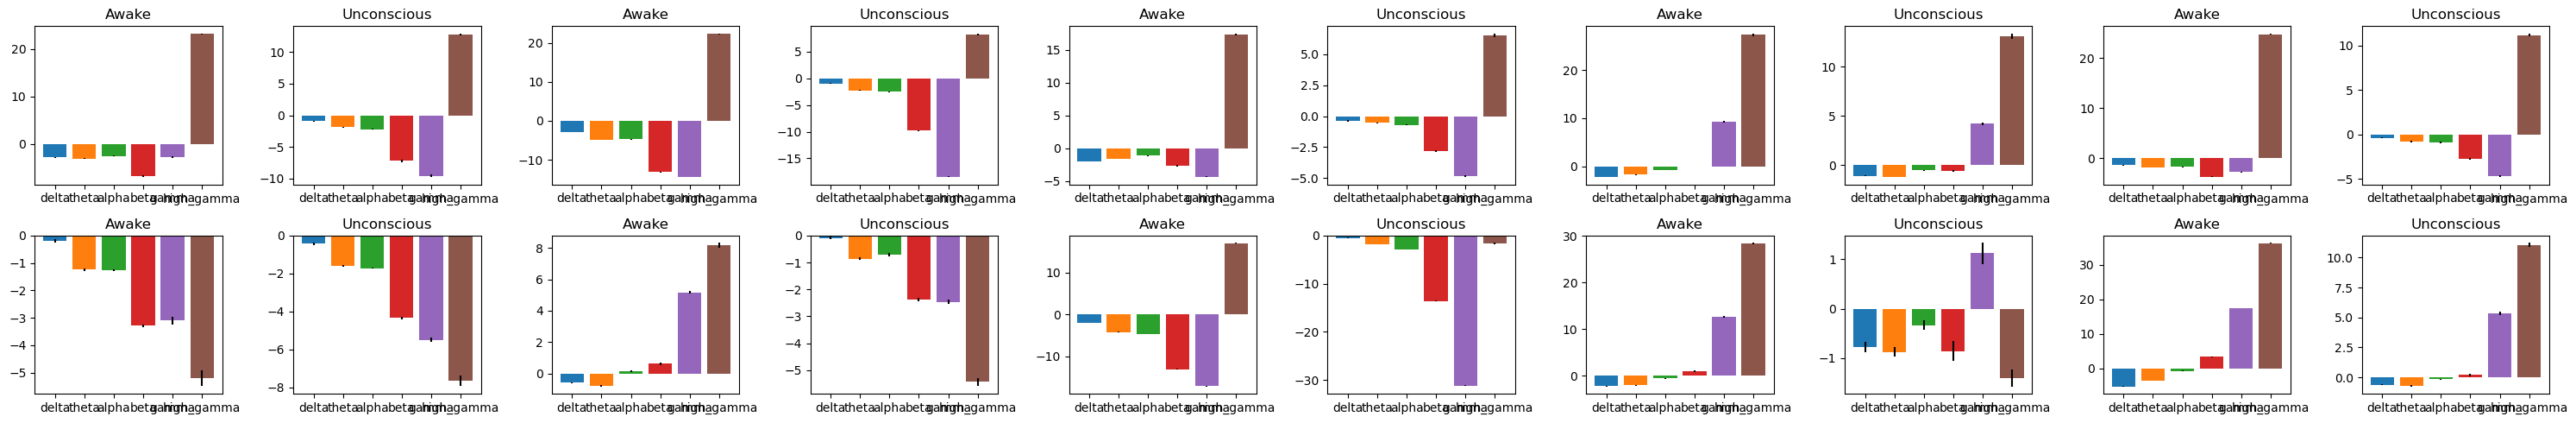

In [68]:
fig, axs = plt.subplots(2, 10, figsize=(30, 5))

for i, session in enumerate(mean_stab.keys()):
    for j, area in enumerate(mean_stab[session].keys()):
        ax = axs[i][2*j]
        for band in band_info.keys():
            key = 'wake_' + band
            ax.bar(band, mean_stab[session][area][key], yerr=se_stab[sesion][area][key])
            ax.set_title('Awake')
            
        ax = axs[i][2*j + 1]
        for band in band_info.keys():
            key = 'anesthesia_' + band
            ax.bar(band, mean_stab[session][area][key], yerr=se_stab[sesion][area][key])
            ax.set_title('Unconscious')
plt.tight_layout()

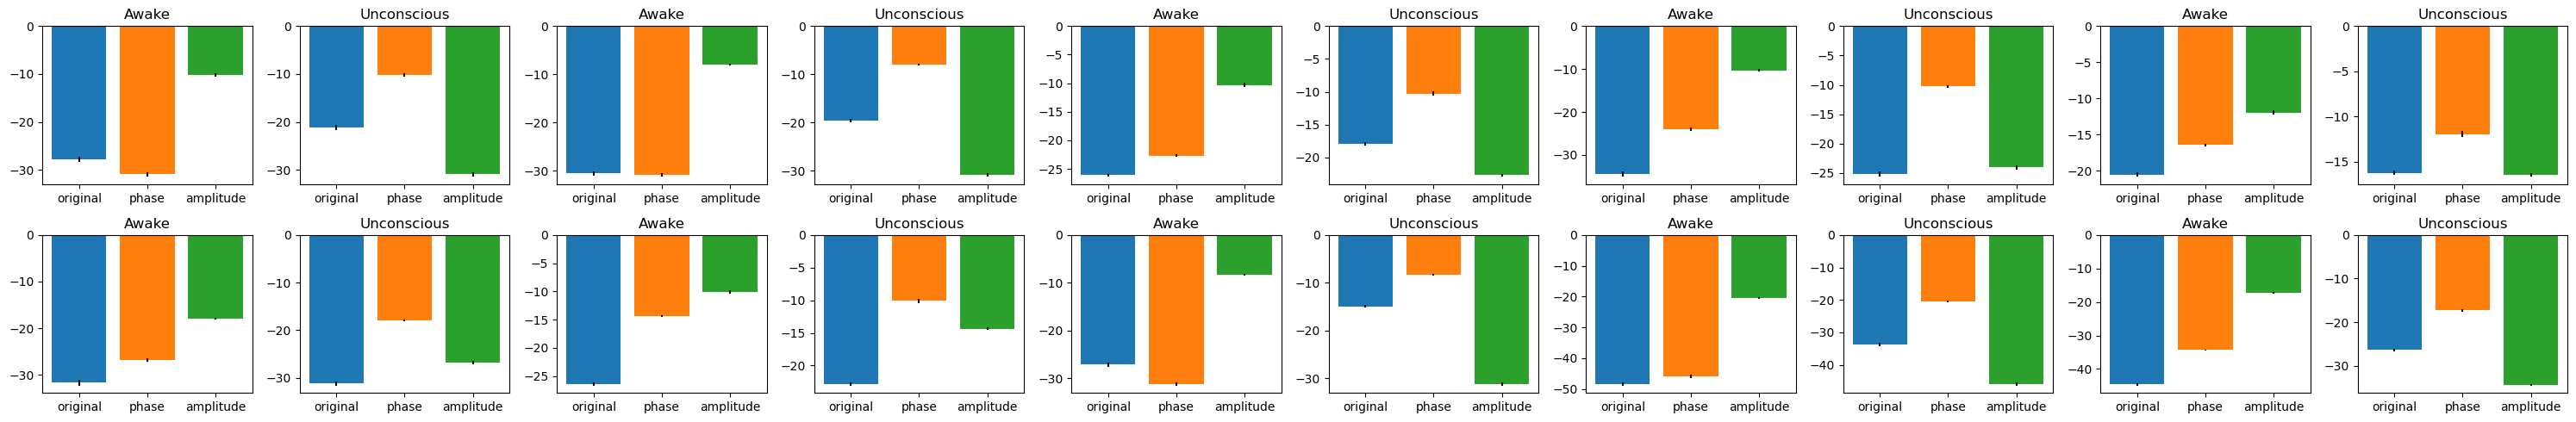

In [66]:
fig, axs = plt.subplots(2, 10, figsize=(30, 5))

for i, session in enumerate(mean_stab.keys()):
    for j, area in enumerate(mean_stab[session].keys()):
        ax = axs[i][2*j]
        for k, key in enumerate(['wake', 'wake_phase_swapped', 'wake_amp_swapped']):
            ax.bar(labels[k], mean_stab[session][area][key], yerr=se_stab[sesion][area][key])
            ax.set_title('Awake')
            
        ax = axs[i][2*j + 1]
        for k, key in enumerate(['anesthesia', 'anesthesia_phase_swapped', 'anesthesia_amp_swapped']):
            ax.bar(labels[k], mean_stab[session][area][key], yerr=se_stab[sesion][area][key])
            ax.set_title('Unconscious')
plt.tight_layout()

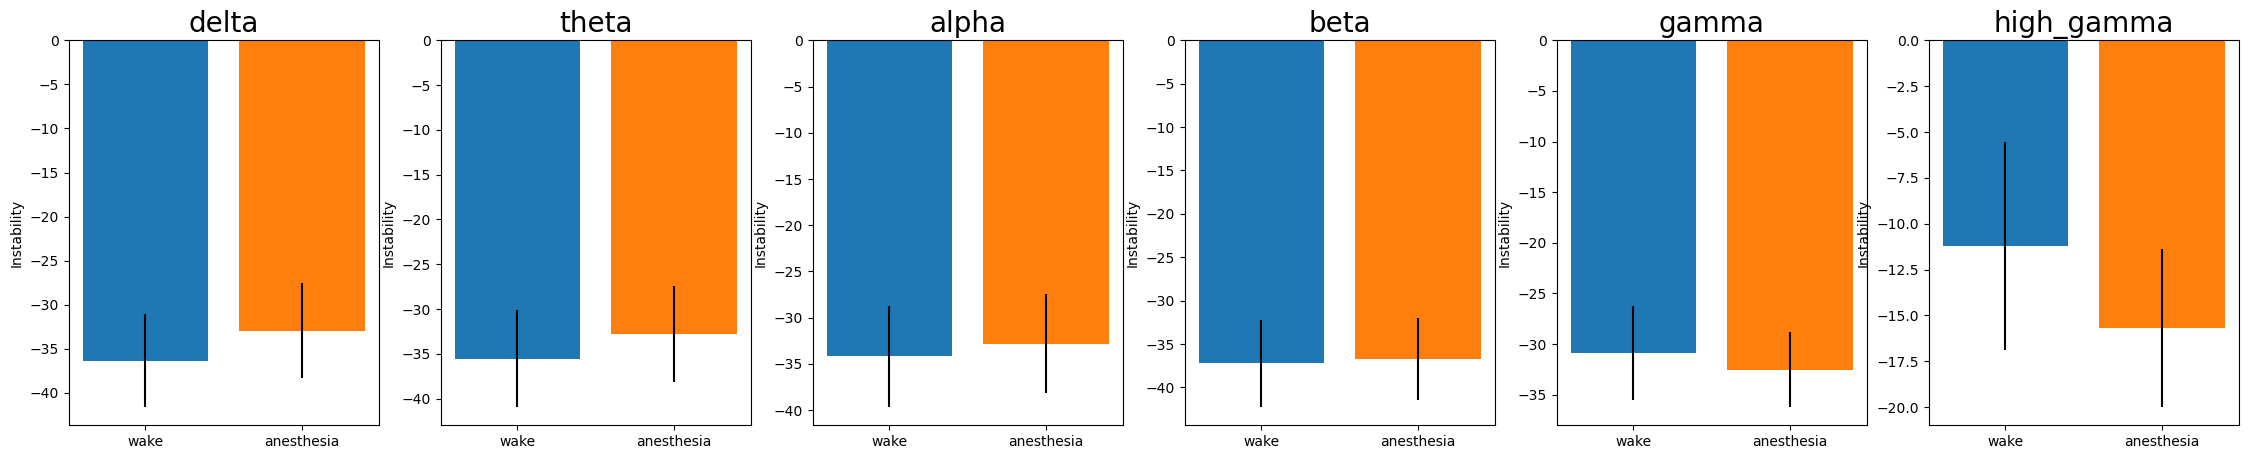

In [55]:
fig, axs = plt.subplots(1, len(band_info), figsize=(28, 5))
for i, band in enumerate(band_info.keys()):
    ax = axs[i]
    key = f'wake_{band}'
    vals = stab_rets[key]['stability_params'][:int(top_percent*len(stab_rets[key]['stability_params']))]
    ax.bar('wake', vals.mean(), yerr=vals.std()/np.sqrt(len(vals)))
    
    key = f'anesthesia_{band}'
    vals = stab_rets[key]['stability_params'][:int(top_percent*len(stab_rets[key]['stability_params']))]
    ax.bar('anesthesia', vals.mean(), yerr=vals.std()/np.sqrt(len(vals)))
    
    ax.set_title(band, fontsize=20)
    ax.set_ylabel('Instability')

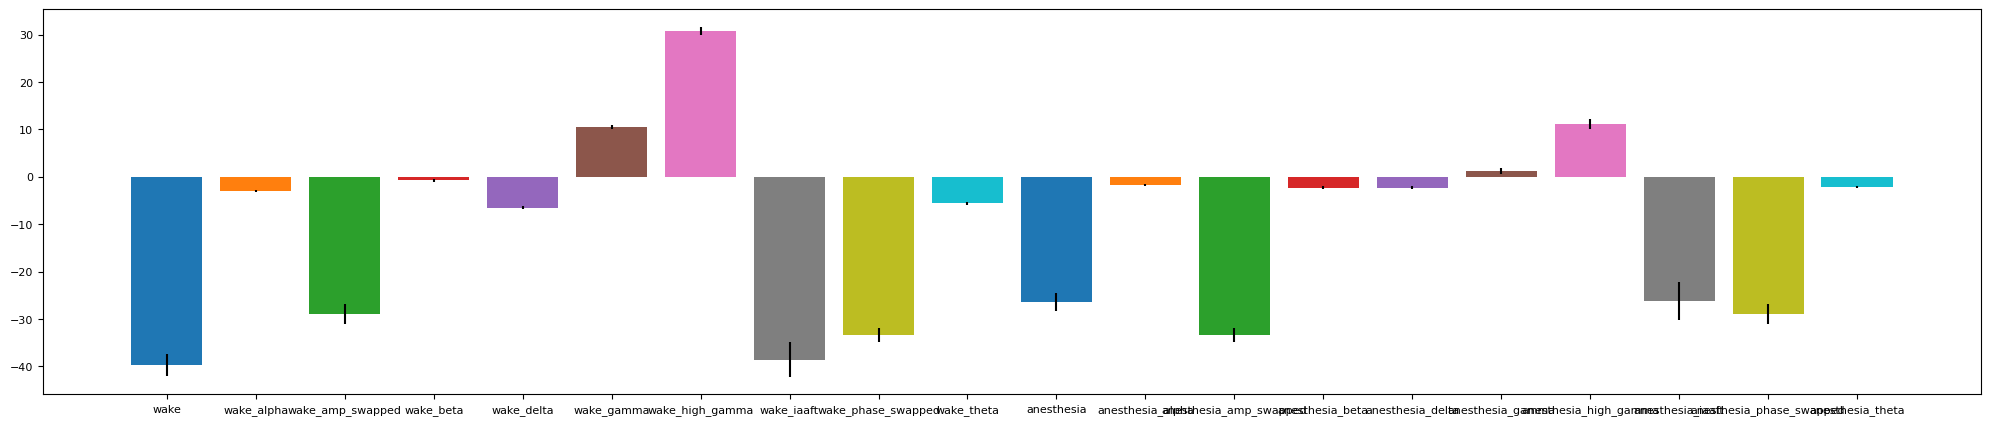

In [352]:
plt.figure(figsize=(25, 5))
ax = plt.gca()
for key in key_list:
    vals = stab_rets[key]['stability_params'][:int(top_percent*len(stab_rets[key]['stability_params']))]
    #     plt.plot(vals, label=key)
    ax.bar(key, vals.mean(), yerr=vals.std()/np.sqrt(len(vals)))
ax.tick_params(labelsize=8)
# plt.legend()

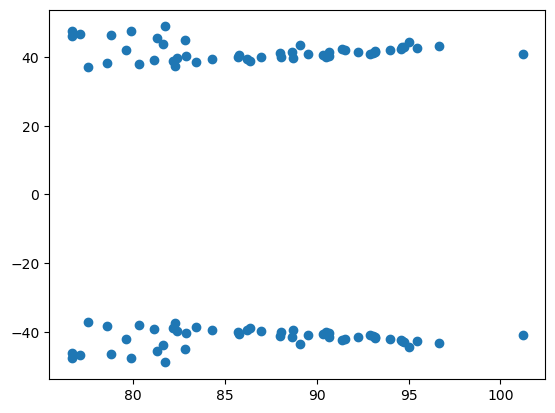

In [324]:
plt.scatter(stab_rets['wake_high_gamma']['stability_params'][:100], stab_rets['wake_high_gamma']['stability_freqs'][:100])

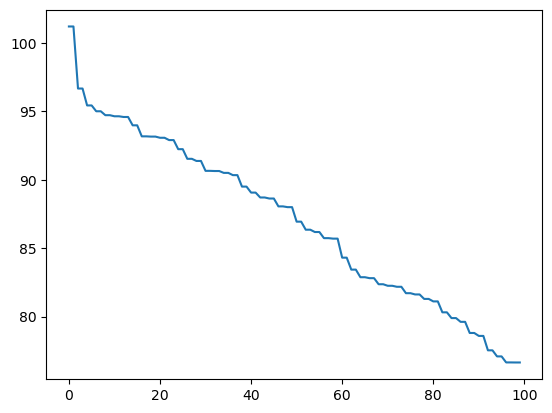

In [322]:
plt.plot(stab_rets['wake_high_gamma']['stability_params'][:100])

### Temp

In [ ]:
fft_vals = 10*np.log10(np.abs(np.fft.rfft(signals['anesthesia'][:, 0])))
fft_vals2 = 10*np.log10(np.abs(np.fft.rfft(sig[:, 0])))
freq = np.fft.rfftfreq(len(fft_vals)*2 - 1, dt)
freq_inds = np.logical_and(freq >= min_freq, freq <= max_freq)
sig.max() > 1e5
plt.plot(freq[freq_inds], fft_vals[freq_inds])
plt.plot(freq[freq_inds], fft_vals2[freq_inds])
plt.axvline(bounds[0], linestyle='--', c='k')
plt.axvline(bounds[1], linestyle='--', c='k')